In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('card_transaction_clean.csv')
df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


### Exploratory Data Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

Let's take a look at these categorical features:
- accountNumber
- customerId
- creditLimit
- cardCVV
- enteredCVV
- cardLast4Digits

In [15]:
df[['accountNumber', 'customerId', 'creditLimit',  'cardCVV', 'enteredCVV', 'cardLast4Digits']].head(5)

,accountNumber,customerId,creditLimit,cardCVV,enteredCVV,cardLast4Digits
0,737265056,737265056,5000,414,414,1803
1,737265056,737265056,5000,486,486,767
2,737265056,737265056,5000,486,486,767
3,737265056,737265056,5000,486,486,767
4,830329091,830329091,5000,885,885,3143


In [17]:
df[['accountNumber', 'customerId', 'creditLimit',  'cardCVV', 'enteredCVV', 'cardLast4Digits']].nunique()

accountNumber      5000
customerId         5000
creditLimit          10
cardCVV             899
enteredCVV          976
cardLast4Digits    5245
dtype: int64

In [19]:
#Check if accountNumber and customerId are the same for all rows
df[(df['accountNumber']) != (df['customerId'])]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud


accountNumber and customerId are the same across all rows. I will drop accountNumber from the dataset to reduce redundancy.

In [24]:
df = df.drop(['accountNumber'], axis=1)

customerId is categorical variable but is stored as integer because of its numerical format. I will convert it to categorical type.

In [27]:
#Convert numerical type to categorical type
df['customerId'] = df['customerId'].astype('category')

I will drop cardLast4Digits

In [30]:
df = df.drop(['cardLast4Digits'], axis=1)

If 'enteredCVV' is different from 'cardCVV', it may be a signal for suspicious behavior. I will create a new binary feature called "isMatchedCVV" to see if 'enteredCVV' is the same as 'cardCVV'. I will then drop 'enteredCVV' and 'cardCVV' columns.

In [33]:
df['isMatchedCVV'] = df['cardCVV'] == df['enteredCVV']
df=df.drop(columns=['enteredCVV', 'cardCVV'], axis=1)

To analyze categorical variables more effectively, I will create a reusable function called explore_categorical that I can apply to each variable in the dataset.

I want to see:

- how frequent each category is
- how fraud is distributed across categories

In [39]:
def explore_categorical(col_name):
    #Number of time each category appears
    print("{0} Counts".format(col_name))
    print(df[col_name].value_counts())
    print("\n")

    #Converts the counts into percentages
    print("{0} Ratio".format(col_name))
    print(df[col_name].value_counts(normalize=True))
    print("\n")

    #Number of time fraud and non-fraud occurred
    print("{0} Default Counts".format(col_name))
    print(df.groupby(col_name, observed=False)['isFraud'].value_counts().unstack(level=-1))
    print("\n")

    #Converts the counts into percentages
    print("{0} Default Ratio".format(col_name))
    print(df.groupby(col_name, observed=False)['isFraud'].value_counts(normalize=True).unstack(level=-1))

In [41]:
explore_categorical('creditLimit')

creditLimit Counts
creditLimit
5000     201863
15000    139307
7500      97913
2500      75429
20000     68629
10000     56889
50000     48781
1000      36430
250       34025
500       27097
Name: count, dtype: int64


creditLimit Ratio
creditLimit
5000     0.256705
15000    0.177154
7500     0.124514
2500     0.095921
20000    0.087274
10000    0.072344
50000    0.062034
1000     0.046327
250      0.043269
500      0.034459
Name: proportion, dtype: float64


creditLimit Default Counts
isFraud       False  True 
creditLimit               
250           33618    407
500           26632    465
1000          35884    546
2500          74313   1116
5000         198336   3527
7500          96623   1290
10000         56123    766
15000        136762   2545
20000         67715    914
50000         47940    841


creditLimit Default Ratio
isFraud         False     True 
creditLimit                    
250          0.988038  0.011962
500          0.982839  0.017161
1000         0.985012  0.0149

- The most common credit limit is 5,000 (25.7% of all customers), followed by 15,000 and 7,500.
- The highest fraud ratios are 15,000 credit limit with 1.83%, followed by 5,000 and 50,000.

In [44]:
explore_categorical('merchantName')

merchantName Counts
merchantName
Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
                                 ...  
Sprint Communications #561941        2
Runners #383214                      2
Curves #849125                       1
EZ Wireless #149871                  1
TMobile Wireless #602341             1
Name: count, Length: 2490, dtype: int64


merchantName Ratio
merchantName
Uber                             0.032571
Lyft                             0.032457
oldnavy.com                      0.021608
staples.com                      0.021593
alibaba.com                      0.021566
                                   ...   
Sprint Communications #561941    0.000003
Runners #383214                  0.000003
Curves #849125                   0.000001
EZ Wireless #149871              0.000001
TMobile Wireless #602341         0.000001
Na

- The top merchants by frequency are Uber (3.26%) and Lyft (3.25%).
- Merchants like walmart.com (2.64%), 1st Pub (2.75%), and staples.com (2.35%) have relatively higher fraud rates.

In [47]:
explore_categorical('transactionType')

transactionType Counts
transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
UNKNOWN                    698
Name: count, dtype: int64


transactionType Ratio
transactionType
PURCHASE                0.947645
REVERSAL                0.025819
ADDRESS_VERIFICATION    0.025648
UNKNOWN                 0.000888
Name: proportion, dtype: float64


transactionType Default Counts
isFraud                False  True 
transactionType                    
ADDRESS_VERIFICATION   20053    116
PURCHASE              733243  11950
REVERSAL               19966    337
UNKNOWN                  684     14


transactionType Default Ratio
isFraud                  False     True 
transactionType                         
ADDRESS_VERIFICATION  0.994249  0.005751
PURCHASE              0.983964  0.016036
REVERSAL              0.983401  0.016599
UNKNOWN               0.979943  0.020057


- PURCHASE makes up the vast majority of all fraud.
- ADDRESS_VERIFICATION has the lowest fraud rate.
- UNKNOWN transaction type has the highest fraud rate.

In [52]:
explore_categorical('merchantCountryCode')

merchantCountryCode Counts
merchantCountryCode
US         778511
MEX          3143
CAN          2426
PR           1559
UNKNOWN       724
Name: count, dtype: int64


merchantCountryCode Ratio
merchantCountryCode
US         0.990015
MEX        0.003997
CAN        0.003085
PR         0.001983
UNKNOWN    0.000921
Name: proportion, dtype: float64


merchantCountryCode Default Counts
isFraud               False  True 
merchantCountryCode               
CAN                    2370     56
MEX                    3079     64
PR                     1532     27
UNKNOWN                 642     82
US                   766323  12188


merchantCountryCode Default Ratio
isFraud                 False     True 
merchantCountryCode                    
CAN                  0.976917  0.023083
MEX                  0.979637  0.020363
PR                   0.982681  0.017319
UNKNOWN              0.886740  0.113260
US                   0.984344  0.015656


- UNKNOWN merchantCountryCode shows highest fraud rate (11.3%)
- Non-US countries have slightly higher fraud rates than the US
- Given the volume of US transactions, most fraud still happens in the US

In [58]:
explore_categorical('customerId')

customerId Counts
customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
787335399        1
220057198        1
897071504        1
622138951        1
238928524        1
Name: count, Length: 5000, dtype: int64


customerId Ratio
customerId
380680241    0.041775
882815134    0.016772
570884863    0.013819
246251253    0.012936
369308035    0.009193
               ...   
787335399    0.000001
220057198    0.000001
897071504    0.000001
622138951    0.000001
238928524    0.000001
Name: proportion, Length: 5000, dtype: float64


customerId Default Counts
isFraud     False  True 
customerId              
100088067      74      1
100108752      18      0
100328049     103      0
100663626      31      0
100737756     177      1
...           ...    ...
999086814     672      5
999257059     158      2
999258704      87      1
999283629     141      0
999389635       9      0

[5000 rows x 2 columns]


customerId Default Rati

- There are 5,000 unique customers.
- Some customers have tens of thousands of transactions and some only have 1 transactions.
- A large number of customers have no fraud history.
- I will drop this column after finishing explore & preprocess the dataset as it's just an identifier, not a meaningful feature to predict.

In [61]:
explore_categorical('isMatchedCVV')

isMatchedCVV Counts
isMatchedCVV
True     779348
False      7015
Name: count, dtype: int64


isMatchedCVV Ratio
isMatchedCVV
True     0.991079
False    0.008921
Name: proportion, dtype: float64


isMatchedCVV Default Counts
isFraud        False  True 
isMatchedCVV               
False           6812    203
True          767134  12214


isMatchedCVV Default Ratio
isFraud          False     True 
isMatchedCVV                    
False         0.971062  0.028938
True          0.984328  0.015672


- Majority of transactions (99.1%) have matched CVV but fraud is almost 2 times more likely when CVV doesn't match.
- isMatchedCVV is a useful predictive feature as it differentiates fraud vs. non-fraud transactions.

In [67]:
explore_categorical('cardPresent')

cardPresent Counts
cardPresent
False    433495
True     352868
Name: count, dtype: int64


cardPresent Ratio
cardPresent
False    0.551266
True     0.448734
Name: proportion, dtype: float64


cardPresent Default Counts
isFraud       False  True 
cardPresent               
False        424533   8962
True         349413   3455


cardPresent Default Ratio
isFraud         False     True 
cardPresent                    
False        0.979326  0.020674
True         0.990209  0.009791


- Slightly more transactions were made without the card present.
- Transactions without the card present are over 2 times more likely to be fraudulent.

In [70]:
explore_categorical('expirationDateKeyInMatch')

expirationDateKeyInMatch Counts
expirationDateKeyInMatch
False    785320
True       1043
Name: count, dtype: int64


expirationDateKeyInMatch Ratio
expirationDateKeyInMatch
False    0.998674
True     0.001326
Name: proportion, dtype: float64


expirationDateKeyInMatch Default Counts
isFraud                    False  True 
expirationDateKeyInMatch               
False                     772916  12404
True                        1030     13


expirationDateKeyInMatch Default Ratio
isFraud                      False     True 
expirationDateKeyInMatch                    
False                     0.984205  0.015795
True                      0.987536  0.012464


- Almost all transactions had expiration date mismatches (99.87%).
- When the expiration date matches, there is slightly lower fraud rate.

### Continous Variables

In [80]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [82]:
corr = df[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']].corr()
corr.style.background_gradient()

,creditLimit,availableMoney,transactionAmount,currentBalance
creditLimit,1.000000,0.834977,0.005581,0.653652
availableMoney,0.834977,1.000000,-0.010070,0.129332
transactionAmount,0.005581,-0.010070,1.000000,0.023905
currentBalance,0.653652,0.129332,0.023905,1.000000


- creditLimit shows a strong correlation with availableMoney (0.83) and a moderate correlation with currentBalance (0.65).
- To reduce multicollinearity and avoid redundancy among features, I will drop creditLimit from the dataset.

In [86]:
df = df.drop('creditLimit', axis=1)

In [88]:
#Summary statistics for transactionAmount
df.groupby('isFraud')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,135.570249,146.525305,0.0,33.19,86.76,189.39,2011.54
True,12417.0,225.215905,189.551393,0.0,86.00,176.98,311.46,1608.35


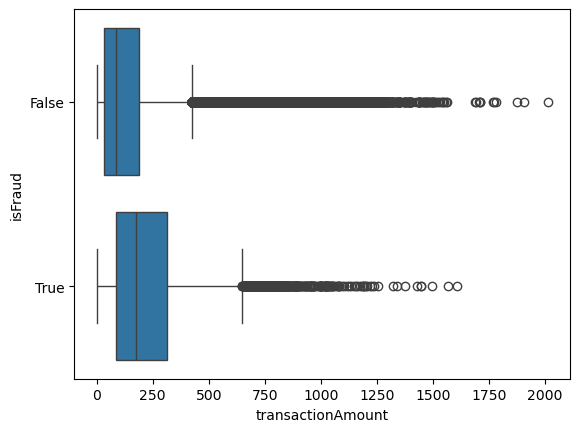

In [90]:
sns.boxplot(x='transactionAmount', y='isFraud', data=df, orient="h")
plt.show()

- Fraudulent transactions have a higher average transaction amount (mean ≈ 225) compared to non-fraudulent ones (mean ≈ 135).
- The median (50%) and upper quartile (75%) values are also notably higher for fraud cases.

In [93]:
print((df['transactionAmount'] == 0).sum())
df[df['transactionAmount'] == 0]['isFraud'].value_counts(normalize=True)

22225


isFraud
False    0.994511
True     0.005489
Name: proportion, dtype: float64

- There are 22,225 transactions that are $0. 
- Only 0.55% of these transactions are frauds so I will not take this into consideration.

In [98]:
#Summary statistics for currentBalance
df.groupby('isFraud')['currentBalance'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,4502.428675,6446.866656,0.0,688.0325,2446.94,5286.10,47498.81
True,12417.0,4902.064338,7074.701649,0.0,822.2100,2747.39,5644.35,47473.94


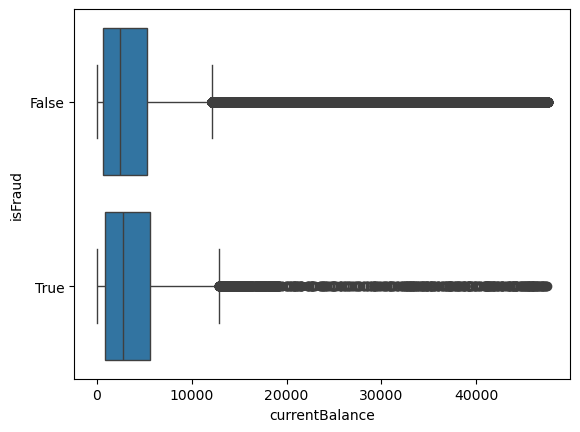

In [100]:
sns.boxplot(x='currentBalance', y='isFraud', data=df, orient="h")
plt.show()

In [102]:
#Summary statistics for availableMoney
df.groupby('isFraud')['availableMoney'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,773946.0,6252.455386,8883.600096,-1005.63,1077.42,3186.145,7500.00,50000.0
True,12417.0,6142.894186,8703.131117,-614.39,1078.02,3120.950,7502.82,50000.0


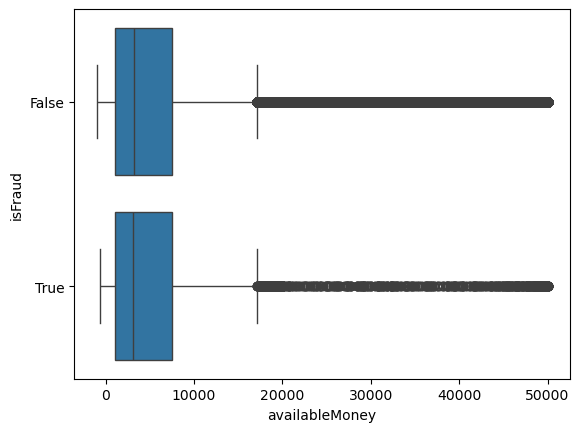

In [104]:
sns.boxplot(x='availableMoney', y='isFraud', data=df, orient="h")
plt.show()

- Fraudulent and non-fraudulent distributions for availableMoney and currentBalance are very similar in terms of mean, median, and spread.
- The boxplots show almost overlapping distributions, with many outliers.

In [107]:
df.to_csv('../downloads/card_transaction_EDA.csv', index=False)